Total thetas: 200
Theta: 200
Theta (rad): 0.0000, Max S Value: 2.0000, Best Angles: {'A1': np.float64(0.0), 'A2': np.float64(1.5707963267948966), 'B1': np.float64(0.0), 'B2': np.float64(-1.5707963267948966)}
Theta (rad): 0.0101, Max S Value: 2.0621, Best Angles: {'A1': np.float64(0.0), 'A2': np.float64(-1.5707963267948966), 'B1': np.float64(0.0), 'B2': np.float64(1.5707963267948966)}
Theta (rad): 0.0201, Max S Value: 2.1222, Best Angles: {'A1': np.float64(0.0), 'A2': np.float64(-1.5707963267948966), 'B1': np.float64(0.0), 'B2': np.float64(1.5707963267948966)}
Theta (rad): 0.0302, Max S Value: 2.1802, Best Angles: {'A1': np.float64(0.0), 'A2': np.float64(-1.5707963267948966), 'B1': np.float64(0.0), 'B2': np.float64(1.5707963267948966)}
Theta (rad): 0.0402, Max S Value: 2.2360, Best Angles: {'A1': np.float64(0.0), 'A2': np.float64(-1.5707963267948966), 'B1': np.float64(0.0), 'B2': np.float64(1.5707963267948966)}
Theta (rad): 0.0503, Max S Value: 2.2896, Best Angles: {'A1': np.float64(0.0

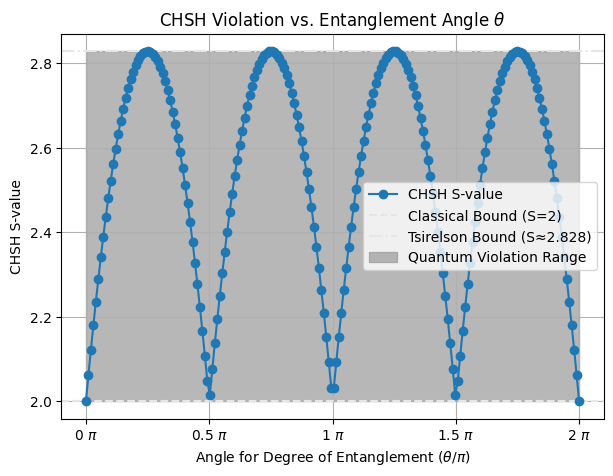

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector, Operator, Pauli
import warnings
warnings.filterwarnings('ignore')
import uuid
import matplotlib.pyplot as plt
import matplotlib.ticker as tck


##############################################################################
# Create Parameterized Entangled State, quantum circuit, create a bell state
# and then apply parametrized ry(theta) to one qubit
##############################################################################
def create_entangled_state(theta):
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    qc.ry(theta, 0)
    return qc
    
##############################################################################
# Measure Correlation <Z Z> after Local Rotations --> returns a real number 
# between +1 and -1 that indicates how correlated (positively or negatively) 
# the two qubits are when measured in the chosen local bases
##############################################################################
def measure_correlation(state, angle_qubit_0, angle_qubit_1):
    """
    `angle_qubit_0` and `angle_qubit_1`
    correspond to rotations about the Y-axis before measuring Z,
    effectively letting us measure along different axes
    """
    # Define R_y(angle) manually as a 2x2 matrix
    # R_y(angle) = [[cos(angle/2), -sin(angle/2)],
    #               [sin(angle/2),  cos(angle/2)]]
    rotation_0 = Operator([
        [np.cos(angle_qubit_0/2), -np.sin(angle_qubit_0/2)],
        [np.sin(angle_qubit_0/2),  np.cos(angle_qubit_0/2)]
    ])
    rotation_1 = Operator([
        [np.cos(angle_qubit_1/2), -np.sin(angle_qubit_1/2)],
        [np.sin(angle_qubit_1/2),  np.cos(angle_qubit_1/2)]
    ])
    
    # Apply local R_y rotations
    rotated_state = state.evolve(rotation_0, [0]).evolve(rotation_1, [1])
    
    # Use Pauli('ZZ') to measure Z \otimes Z on the rotated state
    correlation = np.real(rotated_state.expectation_value(Pauli('ZZ')))
    return correlation

##############################################################################
# 3. Compute the CHSH S-value
##############################################################################
def chsh_s_value(state, angles):
    """
    Given a quantum state and a dictionary of angles:
      angles = {
          'A1': float,
          'A2': float,
          'B1': float,
          'B2': float
      }
    measure:
       S = | <A1 B1> + <A1 B2> + <A2 B1> - <A2 B2> |
    where <A1 B1> means the correlation <Z Z> 
    after rotating each qubit by A1, B1.
    """
    A1B1 = measure_correlation(state, angles['A1'], angles['B1'])
    A1B2 = measure_correlation(state, angles['A1'], angles['B2'])
    A2B1 = measure_correlation(state, angles['A2'], angles['B1'])
    A2B2 = measure_correlation(state, angles['A2'], angles['B2'])
    S = np.abs(A1B1 + A1B2 + A2B1 - A2B2)    # why - is in front of A2B2 and not A1B2 or A2B1??
    return S


##############################################################################
# Main Program
##############################################################################
thetas = np.linspace(0, 2*np.pi, 200)  # 800 unique theta values

print(f"Total thetas: {len(thetas)}")
print(f"Theta: {len(thetas)}")


backend = Aer.get_backend('statevector_simulator')

# Build quantum circuits for each theta
theta_labels = []

circuits = []
for i, theta in enumerate(thetas):
    qc = create_entangled_state(theta)
    qc.name = f"theta_{i}_{uuid.uuid4()}"
    qc.save_statevector(label=f"my_sv_{i}")
    circuits.append(qc)

# Transpile and run
transpiled_circuits = transpile(circuits, backend=backend)
job = backend.run(transpiled_circuits)
result = job.result()

# Initialize variables for tracking
all_s_vals = []
maximum_s_list = []  # Store results for each theta

a1_values = np.linspace(0, 0, 1)

# Define the ranges for theta
#range1 = (0 <= thetas) & (thetas < 1.6) | (3.15 < thetas) & (thetas < 4.7)
#range2 = (1.6 <= thetas) & (thetas <= 3.15) | (4.7 <= thetas) & (thetas <= 2 * np.pi)

# Explore all combinations of angles for each theta
for i, theta in enumerate(thetas):
    # Retrieve the statevector for this theta
    qc_name = transpiled_circuits[i].name
    data_dict = result.data(qc_name)
    state_vector = data_dict[f"my_sv_{i}"]
    state = Statevector(state_vector)

    max_s_for_theta = float('-inf')
    best_angles_for_theta = {}

    for A1 in a1_values:
        a2_values = [A1 + np.pi / 2, A1 - np.pi / 2]

        # Adjust b1_values based on theta range
 #       if range1[i]:
  #          b1_values = [A1 , A1 ]
   #     elif range2[i]:
    #        b1_values = [A1 , A1 ]
        b1_values = [A1 , A1 ]
        for A2 in a2_values:
            for B1 in b1_values:
                b2_values = [B1 + np.pi / 2, B1 - np.pi / 2]
                for B2 in b2_values:
                    angles = {
                        'A1': A1,
                        'A2': A2,
                        'B1': B1,
                        'B2': B2,
                    }

                    # Compute CHSH S-value
                    S = chsh_s_value(state, angles)
                    all_s_vals.append(S)

                    # Track maximum S value for this theta
                    if S > max_s_for_theta:
                        max_s_for_theta = S
                        best_angles_for_theta = angles

    # Store results for this theta
    maximum_s_list.append({
        'Theta': theta,
        'Max S Value': max_s_for_theta,
        'Best Angles': best_angles_for_theta,
    })

    # Print results for this theta
    print(f"Theta (rad): {theta/np.pi:.4f}, Max S Value: {max_s_for_theta:.4f}, Best Angles: {best_angles_for_theta}")


# Debug Output
print(f"Total A1 values explored: {len(a1_values)}")
print(f"Total angle combinations evaluated per theta: {len(a1_values) * 8}")
print(f"Total S values computed: {len(all_s_vals)}")
print(f"Number of Thetas: {len(thetas)}")

# Plot Results
import matplotlib.ticker as tck

# Plot Results with Updated Formatting
fig, ax = plt.subplots(figsize=(7, 5))

# Normalize theta values by dividing by pi                                                                           why? 
normalized_thetas = thetas / np.pi

# Plot the CHSH S-values
ax.plot(normalized_thetas, [result['Max S Value'] for result in maximum_s_list], "o-", label="CHSH S-value", zorder=3)

# Classical and quantum bounds
ax.axhline(y=2, color="0.9", linestyle="--", label="Classical Bound (S=2)")
ax.axhline(y=2 * np.sqrt(2), color="0.9", linestyle="-.", label="Tsirelson Bound (S≈2.828)")
ax.fill_between(normalized_thetas, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7, label="Quantum Violation Range")

# Format x-axis ticks
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5)) # Every 0.5 π

# Labels, legend, and grid
plt.xlabel("Angle for Degree of Entanglement ($\\theta / \\pi$)")      # why do we show the angle divided by pi and it's still with pi on the axis?
plt.ylabel("CHSH S-value")
plt.title("CHSH Violation vs. Entanglement Angle $\\theta$")
plt.legend()
plt.grid(True)

# Save and display the plot
plt.savefig("CHSH_violation_plot_ticks.png")
plt.show()


Comparing it to the theoretically predicted results, there is an apparent shift, even though the shape of the graph looks the same. There might be a systematic offset or phase shift compared to the theoretical predictions? Potential reasons given by ChaatGPT: 

1. Phase Misalignment
In experimental setups, the phase reference for the quantum states (e.g., relative phase between qubits or gates) might differ slightly from the theoretical model, causing a consistent phase shift in the results. 

2. Basis State Mismatch
The basis states used to define the measurement operators in the experiment might differ slightly from those assumed in the theoretical calculation, leading to phase inconsistencies.

3. Theta Initialization:

If the experimental setup or code initializes theta differently from the theoretical calculation (e.g., due to an offset in how theta maps to the physical quantum gates), it could shift the results.

